# Project1
Objectives:  Generate, train, and assess the performance of a neural network which provides meaningful inference for some factors of the selected dataset.

Task:

Generate:

Utilizing the scripts/functions -> PROVIDED HERE Download PROVIDED HERE: train and modify the configuration of the neural network until you arrive at a configuration which provides a test error <~5%.
[THIS PERFORMANCE SHOULD BE FOR THE DATA.CSV FILE ATTACHED BELOW, THIS IS NOT THE DATA GENERATED BY THE SCRIPT EXAMPLE]
An explanation of each training step can be found at the code source link.
Soruce: Building a Neural Network from Scratch in Python: A Step-by-Step Guide | by Okan Yenigün | MediumLinks to an external site.

 

Train: 

Load the data  Download dataand if necessary --> decide on the feature or features you will be predictingLinks to an external site.. Your training process will rely on performing a train / test splitLinks to an external site. to leave some samples out of the training for unbiased assessment. 

1) Select and modify for at least 10 configurations of the following:
    a) network shape
    b) learning rate
    c) batch size
    d) validation size
    e) number of epochs

You should select and modify the parameters of the training relative to the performance you've observed at each step. 

2) Run the model several times* (~5 times) per each configuration). (Turing off verbose can reduce the clutter)

* You can expand your notebook, or generate a spreadsheet like the one we used in our first activity to keep track of the training parameters and the relative performance of each run.

## Video part
https://umsystem.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=f1413219-582e-4fd4-96f5-b1f8013f8c74

## Package

In [32]:
import numpy as np
from typing import List, Dict, Tuple
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## Neural Network Class

In [33]:
class Neural:

    def __init__(self, layers: List[int], epochs: int,
                 learning_rate: float = 0.001, batch_size: int=32,
                 validation_split: float = 0.2, verbose: int=1):
        self._layer_structure: List[int] = layers
        self._batch_size: int = batch_size
        self._epochs: int = epochs
        self._learning_rate: float = learning_rate
        self._validation_split: float = validation_split
        self._verbose: int = verbose
        self._losses: Dict[str, List[float]] = {"train": [], "validation": []}
        self._is_fit: bool = False
        self.__layers = None

    def __sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def __init_layers(self) -> List[np.ndarray]:
        layers = []
        for i in range(1, len(self._layer_structure)):
            layers.append([
                np.random.randn(self._layer_structure[i-1], self._layer_structure[i]) * 0.1,
                np.zeros((1, self._layer_structure[i]))
            ])
        return layers

    def __forward(self, batch: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        hidden = [batch.copy()]
        for i in range(len(self.__layers)):
            batch = np.matmul(batch, self.__layers[i][0]) + self.__layers[i][1]
            if i < len(self.__layers) - 1:
                # hidden layer uses the ReLU activation function
                batch = np.maximum(batch, 0)
            else:
                # output layer uses the Sigmoid activation function
                batch = self.__sigmoid(batch)
            hidden.append(batch.copy())
        return batch, hidden

    def __calculate_loss(self, actual: np.ndarray, predicted: np.ndarray) -> float:
        # binary cross entropy loss
        epsilon = 1e-15  # prevent log(0)
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        loss = - (actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
        return np.mean(loss)

    def __calculate_loss_gradient(self, actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        # binary cross entropy loss gradient to output (combined with Sigmoid activation function)
        grad = predicted - actual
        return grad

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # split validation set
        X, X_val, y, y_val = train_test_split(X, y, test_size=self._validation_split, random_state=42)
        # initialize the layer
        self.__layers = self.__init_layers()
        n_samples = X.shape[0]
        n_batches = max(n_samples // self._batch_size, 1)
        for epoch in range(self._epochs):
            epoch_losses = []
            # shuffle the data
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(n_batches):
                start = i * self._batch_size
                end = start + self._batch_size
                x_batch = X[start:end]
                y_batch = y[start:end]
                # forward propagation
                pred, hidden = self.__forward(x_batch)
                # calculate losses
                loss = self.__calculate_loss(y_batch, pred)
                epoch_losses.append(loss)
                # back propagation
                grad = self.__calculate_loss_gradient(y_batch, pred)
                self.__backward(hidden, grad)
            # validation loss
            valid_preds, _ = self.__forward(X_val)
            train_loss = np.mean(epoch_losses)
            valid_loss = self.__calculate_loss(y_val, valid_preds)
            self._losses["train"].append(train_loss)
            self._losses["validation"].append(valid_loss)
            if self._verbose:
                print(f"Epoch: {epoch+1}/{self._epochs} Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f}")
        self._is_fit = True
        return

    def __backward(self, hidden: List[np.ndarray], grad: np.ndarray) -> None:
        for i in range(len(self.__layers)-1, -1, -1):
            if i != len(self.__layers) - 1:
                # gradient of the ReLU activation function
                grad = grad * (hidden[i+1] > 0).astype(float)

            w_grad = hidden[i].T @ grad / max(grad.shape[0], 1)
            b_grad = np.sum(grad, axis=0, keepdims=True) / max(grad.shape[0], 1)

            self.__layers[i][0] -= self._learning_rate * w_grad
            self.__layers[i][1] -= self._learning_rate * b_grad

            grad = grad @ self.__layers[i][0].T
        return

    def predict(self, X: np.ndarray) -> np.ndarray:
        if not self._is_fit:
            raise Exception("The model has not been trained yet.")
        pred, _ = self.__forward(X)
        return pred

    def plot_learning(self) -> None:
        import matplotlib.pyplot as plt
        plt.plot(self._losses["train"], label="Training loss")
        plt.plot(self._losses["validation"], label="Validation loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Learning Curve")
        plt.show()


## Load and Preprocess the Data

In [34]:
# load the dataset
df = pd.read_csv('data.csv')
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])  # encode labels as 0 and 1

# remove unnecessary columns
df = df.drop(['id', 'Unnamed: 32'], axis=1)

# select features and target variables
X = df[['radius_mean', 'perimeter_mean', 'area_mean', 'concave points_worst', 'perimeter_worst', 'radius_worst', 'concave points_mean']].values
y = df['diagnosis'].values.reshape(-1, 1)

# Standardized features
scaler = StandardScaler()
X = scaler.fit_transform(X)


## Define Hyperparameter Configurations

In [35]:
configurations = [
    # Configuration 1
    {"network_shape": [X.shape[1], 16, 8, 1],
     "learning_rate": 0.01,
     "batch_size": 32,
     "validation_split": 0.2,
     "epochs": 50},
    # Configuration 2
    {"network_shape": [X.shape[1], 32, 16, 8, 1],
     "learning_rate": 0.005,
     "batch_size": 64,
     "validation_split": 0.2,
     "epochs": 50},
    # Configuration 3
    {"network_shape": [X.shape[1], 16, 1],
     "learning_rate": 0.01,
     "batch_size": 16,
     "validation_split": 0.3,
     "epochs": 50},
    # Configuration 4
    {"network_shape": [X.shape[1], 8, 4, 1],
     "learning_rate": 0.001,
     "batch_size": 32,
     "validation_split": 0.1,
     "epochs": 100},
    # Configuration 5
    {"network_shape": [X.shape[1], 64, 32, 16, 1],
     "learning_rate": 0.01,
     "batch_size": 128,
     "validation_split": 0.2,
     "epochs": 50},
    # Configuration 6
    {"network_shape": [X.shape[1], 16, 8, 1],
     "learning_rate": 0.005,
     "batch_size": 32,
     "validation_split": 0.3,
     "epochs": 100},
    # Configuration 7
    {"network_shape": [X.shape[1], 16, 8, 4, 1],
     "learning_rate": 0.01,
     "batch_size": 64,
     "validation_split": 0.2,
     "epochs": 150},
    # Configuration 8
    {"network_shape": [X.shape[1], 32, 1],
     "learning_rate": 0.005,
     "batch_size": 32,
     "validation_split": 0.2,
     "epochs": 100},
    # Configuration 9
    {"network_shape": [X.shape[1], 8, 8, 8, 1],
     "learning_rate": 0.01,
     "batch_size": 16,
     "validation_split": 0.2,
     "epochs": 200},
    # Configuration 10
    {"network_shape": [X.shape[1], 64, 32, 16, 8, 1],
     "learning_rate": 0.001,
     "batch_size": 32,
     "validation_split": 0.2,
     "epochs": 100}
]


## Run Experiments

In [36]:
results = []

for idx, config in enumerate(configurations):
    accuracies = []
    for run in range(5):  # each configuration was run 5 times
        # use different random states to divide the dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=run)
        
        # initialize the model
        nn = Neural(layers=config["network_shape"],
                    epochs=config["epochs"],
                    learning_rate=config["learning_rate"],
                    batch_size=config["batch_size"],
                    validation_split=config["validation_split"],
                    verbose=0)  # close verbose
        
        # train the model
        nn.fit(X_train, y_train)
        
        # preduct and evaluate
        y_pred = nn.predict(X_test)
        y_pred_classes = (y_pred >= 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred_classes)
        accuracies.append(acc)
    
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    results.append({
        "config_index": idx+1,
        "configuration": config,
        "accuracies": accuracies,
        "average_accuracy": avg_acc,
        "std_accuracy": std_acc
    })
    print(f"Configuration {idx+1}: Average Accuracy = {avg_acc:.4f}, Standard Deviation = {std_acc:.4f}")



Configuration 1: Average Accuracy = 0.6807, Standard Deviation = 0.0586
Configuration 2: Average Accuracy = 0.6351, Standard Deviation = 0.0395
Configuration 3: Average Accuracy = 0.9211, Standard Deviation = 0.0157
Configuration 4: Average Accuracy = 0.6351, Standard Deviation = 0.0395
Configuration 5: Average Accuracy = 0.6491, Standard Deviation = 0.0613
Configuration 6: Average Accuracy = 0.7070, Standard Deviation = 0.1018
Configuration 7: Average Accuracy = 0.6351, Standard Deviation = 0.0395
Configuration 8: Average Accuracy = 0.9193, Standard Deviation = 0.0102
Configuration 9: Average Accuracy = 0.9333, Standard Deviation = 0.0205
Configuration 10: Average Accuracy = 0.6351, Standard Deviation = 0.0395


## Analyze Results and save the results in a xlsx file

In [37]:
# determine the maximum number of runs
max_runs = max(len(res['accuracies']) for res in results)

# collect all configuration keys
config_keys = set()
for res in results:
    config_keys.update(res['configuration'].keys())

# create an empty list to store each configuration's results
output_data = []

for res in results:
    config = res["configuration"]
    print(f"\nConfiguration {res.get('config_index', 'N/A')}:")
    for key, value in config.items():
        print(f"{key}: {value}")
    print(f"Accuracies: {res['accuracies']}")
    print(f"Average Accuracy: {res['average_accuracy']:.4f}")
    print(f"Standard Deviation: {res['std_accuracy']:.4f}")
    
    # create a dictionary containing the required information
    result_dict = {
        "Configuration Index": res.get('config_index', 'N/A'),
        "Average Accuracy": f"{res['average_accuracy']:.4f}",
        "Standard Deviation": f"{res['std_accuracy']:.4f}"
    }
    
    # add all key-value pairs from the configuration
    for key in config_keys:
        result_dict[key] = config.get(key, 'N/A')
    
    # add the accuracies from each run
    for i in range(max_runs):
        if i < len(res['accuracies']):
            result_dict[f"Accuracy {i+1}"] = f"{res['accuracies'][i]:.4f}"
        else:
            result_dict[f"Accuracy {i+1}"] = ''
    output_data.append(result_dict)

# convert the list of results into a DataFrame
df = pd.DataFrame(output_data)

# save the DataFrame as an xlsx file
df.to_excel('Spreadsheet.xlsx', index=False)

print("Results have been successfully saved to Spreadsheet.xlsx.")



Configuration 1:
network_shape: [7, 16, 8, 1]
learning_rate: 0.01
batch_size: 32
validation_split: 0.2
epochs: 50
Accuracies: [0.7807017543859649, 0.6578947368421053, 0.6052631578947368, 0.6578947368421053, 0.7017543859649122]
Average Accuracy: 0.6807
Standard Deviation: 0.0586

Configuration 2:
network_shape: [7, 32, 16, 8, 1]
learning_rate: 0.005
batch_size: 64
validation_split: 0.2
epochs: 50
Accuracies: [0.5877192982456141, 0.631578947368421, 0.6052631578947368, 0.6491228070175439, 0.7017543859649122]
Average Accuracy: 0.6351
Standard Deviation: 0.0395

Configuration 3:
network_shape: [7, 16, 1]
learning_rate: 0.01
batch_size: 16
validation_split: 0.3
epochs: 50
Accuracies: [0.9210526315789473, 0.9385964912280702, 0.9035087719298246, 0.9385964912280702, 0.9035087719298246]
Average Accuracy: 0.9211
Standard Deviation: 0.0157

Configuration 4:
network_shape: [7, 8, 4, 1]
learning_rate: 0.001
batch_size: 32
validation_split: 0.1
epochs: 100
Accuracies: [0.5877192982456141, 0.63157894

## Plot a bar chart of the average accuracies.

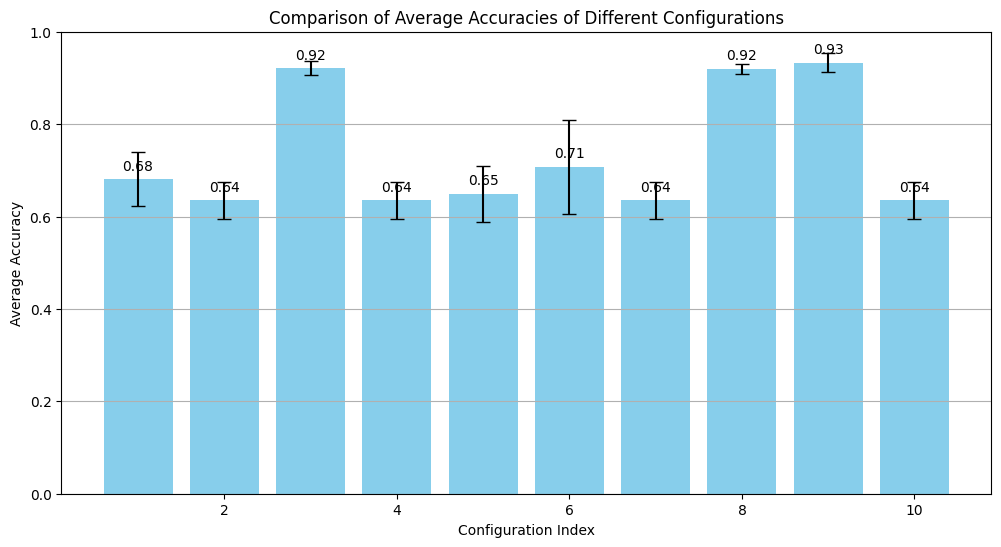

In [38]:
# Extract configuration indices, average accuracies, and standard deviations
config_indices = [res.get('config_index', 'N/A') for res in results]
average_accuracies = [res['average_accuracy'] for res in results]
std_accuracies = [res['std_accuracy'] for res in results]

# Convert average accuracies and standard deviations to float lists
average_accuracies = [float(acc) for acc in average_accuracies]
std_accuracies = [float(std) for std in std_accuracies]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(config_indices, average_accuracies, yerr=std_accuracies, capsize=5, color='skyblue')
plt.xlabel('Configuration Index')
plt.ylabel('Average Accuracy')
plt.title('Comparison of Average Accuracies of Different Configurations')
plt.ylim([0, 1])  # Accuracy range from 0 to 1
plt.grid(axis='y')

# Add accuracy value labels
for i, acc in enumerate(average_accuracies):
    plt.text(config_indices[i], acc + 0.02, f"{acc:.2f}", ha='center')

# Display the chart
plt.show()


## Plot the learning curve

In [40]:
# Select the configuration index for which you want to plot the learning curve
target_config_index = 3  # Replace with the configuration index 

# Find the corresponding configuration and model in results
for res in results:
    if res.get('config_index', 'N/A') == target_config_index:
        target_config = res['configuration']
        break

# Retrain the model to obtain loss data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

nn = Neural(layers=target_config["network_shape"],
            epochs=target_config["epochs"],
            learning_rate=target_config["learning_rate"],
            batch_size=target_config["batch_size"],
            validation_split=target_config["validation_split"],
            verbose=0)

nn.fit(X_train, y_train)

# Extract loss data
train_losses = nn._losses["train"]
val_losses = nn._losses["validation"]
epochs_range = range(1, len(train_losses) + 1)



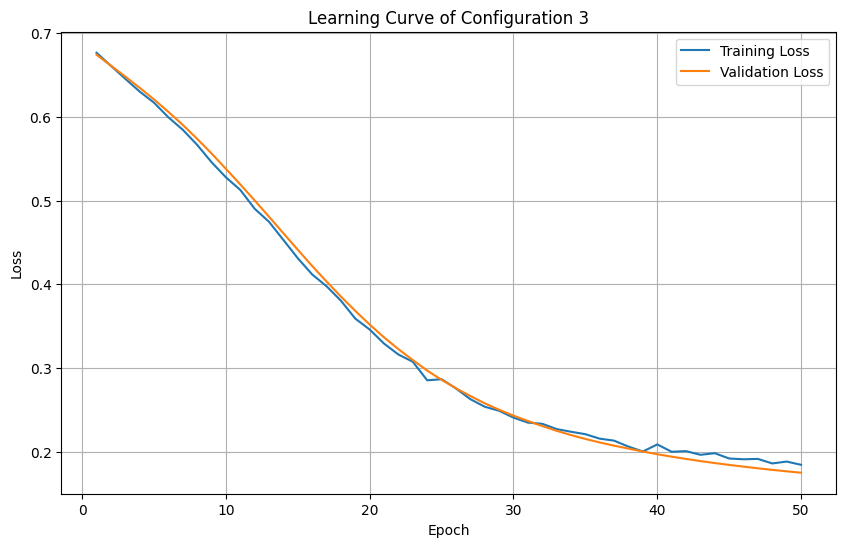

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Learning Curve of Configuration {target_config_index}')
plt.legend()
plt.grid(True)
plt.show()



## Plot the average accuracy comparison of multiple configurations

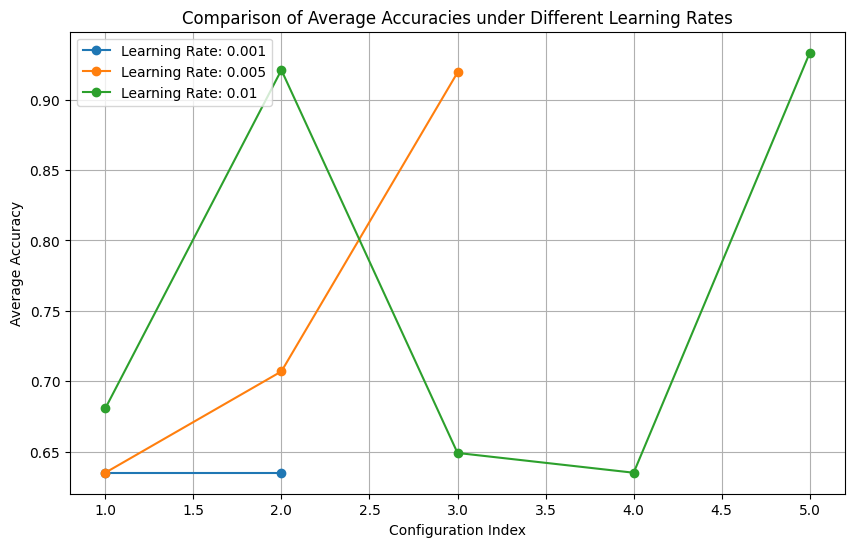

In [42]:
# Extract learning rates and corresponding average accuracies
learning_rates = [res['configuration']['learning_rate'] for res in results]
unique_learning_rates = sorted(set(learning_rates))

# Create a dictionary where the key is the learning rate and the value is a list of average accuracies for that rate
lr_accuracy_dict = {lr: [] for lr in unique_learning_rates}

for res in results:
    lr = res['configuration']['learning_rate']
    acc = float(res['average_accuracy'])
    lr_accuracy_dict[lr].append(acc)

# Plot the line chart
plt.figure(figsize=(10, 6))

for lr, acc_list in lr_accuracy_dict.items():
    plt.plot(range(1, len(acc_list)+1), acc_list, marker='o', label=f'Learning Rate: {lr}')

plt.xlabel('Configuration Index')
plt.ylabel('Average Accuracy')
plt.title('Comparison of Average Accuracies under Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()
